In [1]:
# Going to make this section dedicated to data analysis and Data Pipeline development

#### Datapipeline Notes:
- Get a V1 out ASAP
- Pull from a list of tickers that we want to track
- Get data from those tickers for yahoo finance (save those immediately to a CSV: Raw data that we have locally)
- From the CSVs that we have (referencing tickers)
    - MAP
    - Transform the data based on optional "Transform Objects"
        - Normalize or Standardize
        - Deseasonalize (present the returns)
    - Reduce
- Save data to a new train CSV (and then we're done!)

In [2]:
!pip install seaborn

You should consider upgrading via the 'c:\users\ethan ohman\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# import basic libaries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# object libraries
import json 
import pickle 

# basic datascience libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# import OOP libaries
from abc import ABC, abstractmethod
from dataclasses import dataclass
import typing

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [44]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from copy import deepcopy

In [3]:
TICKERS = ["^GSPC"] # add more later!
with open("sp_500_stock_list.json", "rb") as json_file:
    SP_500_TICKERS = json.load(json_file)

In [5]:
data = yf.download(TICKERS[0], period="max", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [6]:
features_data = data[["Open", "Volume", "Low", "High"]]
target_data = data[["Adj Close", "Close"]]

In [7]:
class PipelineDataTransform(ABC):
    def __init__(self, *args, **kwargs):
        pass
    
    @abstractmethod
    def apply_transformation(self, *args, **kwargs):
        raise NotImplementedError("implement me")

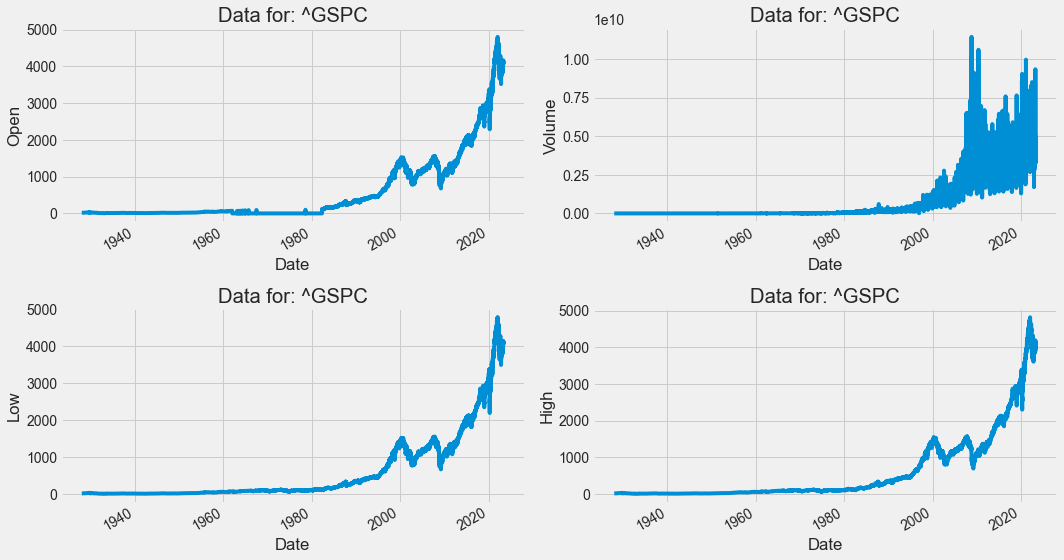

In [8]:
plt.figure(figsize=(15,8))
for i, column in enumerate(features_data.columns, 1):
    plt.subplot(2,2,i)
    features_data[column].plot()
    plt.xlabel("Date")
    plt.ylabel(str(column))
    plt.title(f"Data for: {TICKERS[0]}")
plt.tight_layout()

In [7]:
features_data.index

DatetimeIndex(['1927-12-30', '1928-01-03', '1928-01-04', '1928-01-05',
               '1928-01-06', '1928-01-09', '1928-01-10', '1928-01-11',
               '1928-01-12', '1928-01-13',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='Date', length=23946, freq=None)

#### Finding Covariances Among Stocks (S&P 500)

In [22]:
LIMIT = 100

In [37]:
closing_price_stock_dict = {}
date_keys = []
close_keys = []

for ticker in SP_500_TICKERS[:LIMIT]:
    ticker_df = yf.download(ticker, period="max", interval="1d")
    ticker_dates = ticker_df.index
    date_key, close_key = f"{ticker} Date", f"{ticker} Close"
    closing_price_stock_dict[date_key] = list(sorted(ticker_dates))
    closing_price_stock_dict[close_key] = list(ticker_df["Close"])
    
    # add keys for later use
    date_keys.append(date_key)
    close_keys.append(close_key)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [45]:
starting_date = max([min(closing_price_stock_dict[dk]) for dk in date_keys])
ending_date = min([max(closing_price_stock_dict[dk]) for dk in date_keys])

date_index = deepcopy(closing_price_stock_dict[date_keys[0]])
relative_start = date_index.index(starting_date)
relative_end = date_index.index(ending_date)

date_index = date_index[relative_start:relative_end+1]

In [66]:
closing_price_stock_df = pd.DataFrame()
closing_price_stock_df["Date"] = date_index
closing_price_stock_df.set_index("Date", inplace=True, drop=True)

for date_key, close_key in zip(date_keys, close_keys):
    ind = closing_price_stock_dict[date_key].index(starting_date)
    closing_price_stock_df[close_key] = closing_price_stock_dict[close_key][ind:]



<Axes: >

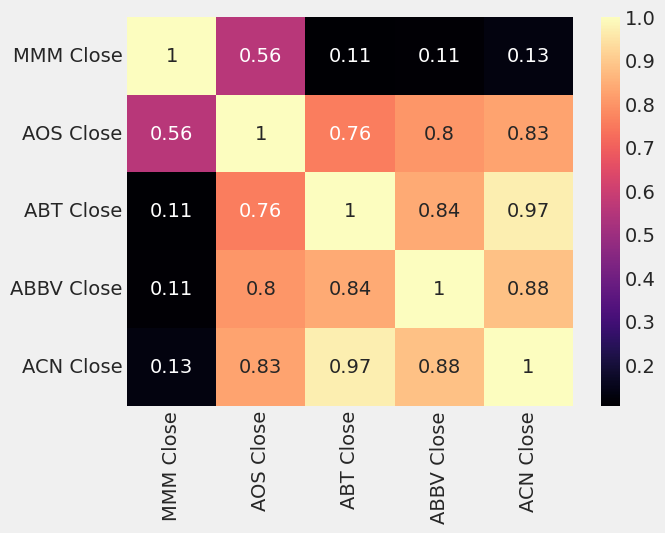

In [69]:
sns.heatmap(closing_price_stock_df.corr(), annot=True, cmap="magma")